# Processing Exodus-files in Python

Here a quick first test to load Exodus files (result files from MOOSE) with python to inspect results and to generate high-quality figures.

As a first step, make sure that `netcdf4` is installed. Actually, this should simply be possible using Anaconda:

`conda install netcdf4`

In [1]:
import netCDF4

In [2]:
import numpy as np

We can now simply load the exodus file as a netcdf-object (I am actually quite impressed that this is working so easily...):

In [3]:
nc = netCDF4.Dataset('Florian_Benchmark/1-T/T_2D_small_out.e')

We can first have a quick view at the variables:

In [4]:
nc.variables

OrderedDict([('time_whole', <class 'netCDF4._netCDF4.Variable'>
              float64 time_whole(time_step)
              unlimited dimensions: time_step
              current shape = (2,)
              filling off), ('eb_status', <class 'netCDF4._netCDF4.Variable'>
              int32 eb_status(num_el_blk)
              unlimited dimensions: 
              current shape = (1,)
              filling off), ('eb_prop1', <class 'netCDF4._netCDF4.Variable'>
              int32 eb_prop1(num_el_blk)
                  name: ID
              unlimited dimensions: 
              current shape = (1,)
              filling off), ('ns_status', <class 'netCDF4._netCDF4.Variable'>
              int32 ns_status(num_node_sets)
              unlimited dimensions: 
              current shape = (4,)
              filling off), ('ns_prop1', <class 'netCDF4._netCDF4.Variable'>
              int32 ns_prop1(num_node_sets)
                  name: ID
              unlimited dimensions: 
              current 

In [5]:
X = nc.variables['coordx']
Y = nc.variables['coordy']
connect = nc.variables['connect1']
print(connect[0:10])

[[ 1  2  3  4]
 [ 2  5  6  3]
 [ 5  7  8  6]
 [ 7  9 10  8]
 [ 9 11 12 10]
 [11 13 14 12]
 [13 15 16 14]
 [15 17 18 16]
 [17 19 20 18]
 [19 21 22 20]]


Now some of the standard imports for further processing:

In [6]:
%matplotlib inline
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Plot results for arbitrary FE mesh

Technically, this should be possible (see example on http://johntfoster.github.io/posts/extracting-exodus-information-with-netcdf-python.html) - however, it doesn't work yet, probably worth investigating a bit more in the future:

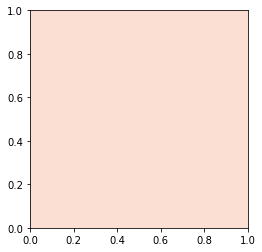

In [81]:
xy = np.array([X[:], Y[:]]).T

patches = []
for coords in xy[connect[:]-1]:
    quad = Polygon(coords, True)
    patches.append(quad)

fig, ax = plt.subplots()
colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, cmap=matplotlib.cm.coolwarm, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
# ax.set_xlim([-4, 4])
# ax.set_ylim([-4, 4])
ax.set_aspect('equal')
plt.show()

## Presenting results on regular grid

Luckily, the results are in this case on a regular grid - so plotting them is straight-forward. First, we note that the X- and Y- variables contain the coordinates:

In [13]:
X[:], Y[:]

(array([    0.,    40.,    40., ...,  1920.,  1960.,  2000.]),
 array([    0.,     0.,    40., ...,  1000.,  1000.,  1000.]))

Here a quick scatter plot to visualise these points:

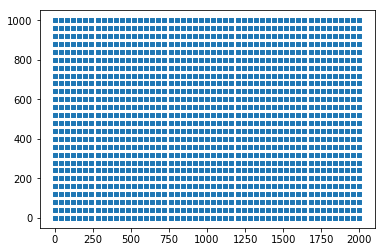

In [82]:
plt.scatter(X[:], Y[:], marker='s', s=10)

## Extract variable information

As a next step, we need to extract the information at the variable positions. First, let's look at all the information in the Exodus file:

In [16]:
for key,var in nc.variables.items():
    print(key)
    

time_whole
eb_status
eb_prop1
ns_status
ns_prop1
ss_status
ss_prop1
coordx
coordy
eb_names
ns_names
ss_names
coor_names
node_num_map
connect1
elem_num_map
elem_ss1
side_ss1
elem_ss2
side_ss2
elem_ss3
side_ss3
elem_ss4
side_ss4
node_ns1
node_ns2
node_ns3
node_ns4
vals_nod_var1
vals_nod_var2
name_nod_var
name_elem_var
vals_elem_var1eb1
vals_elem_var2eb1
vals_elem_var3eb1
elem_var_tab
info_records


We seem to have information on both, nodes and elements. Temperature seems to be stored in variable 2 of the node-vars (check: is this the same ordering as in Paraview? Would make inspecting the file quite a bit easier):

In [26]:
var1 = nc.variables['name_nod_var']

In [86]:
print(var1)

<class 'netCDF4._netCDF4.Variable'>
|S1 name_nod_var(num_nod_var, len_name)
unlimited dimensions: 
current shape = (2, 33)
filling off



In [37]:
var2 = nc.variables['vals_nod_var2']

As a final step, we can now use this information to create a plot with `matplotlib`. Note that the fancy way of adding the colorbar is not required, but I quite like it (to get consistent scaling).

With the last command, we save the figure to a file. The file format can simply be adjusted with the extension. For the presentation in LaTeX, `.eps`-files are ideal - and these can further be post-processed using conventional vector-graphics software (Corel, Adobe, Inkscape, etc.):

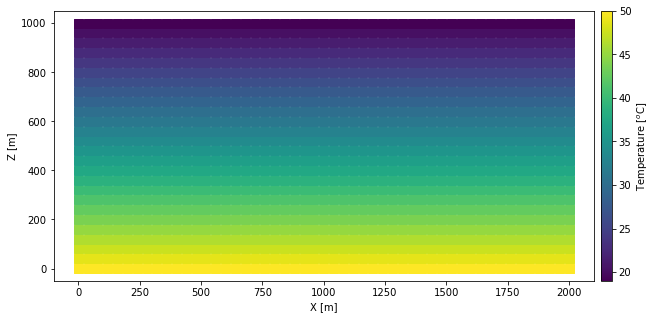

In [87]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.scatter(X, Y, c=var2[1,:], marker='s', s=80)
ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Temperature [$^o$C]")
ax.set_aspect('equal')
plt.savefig("temperature.eps")